<a href="https://colab.research.google.com/github/DataBaeDev/Diamond-Project/blob/main/Diamond_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1: Define the Problem

The purpose of this analysis is to answer the following questions using the Diamond Dataset:<br>
- Can a diamond's price be predicted by approximating its volume in milimeters?
- Can a combination of the Depth, Table, and Length/Width Ratio be used to classify a diamond's cut?

#Task 2: Install and Import Libraries

In [100]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pickle
sns.set()

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Task 3: Load the Data

In [102]:
diamond_df = pd.read_csv('https://raw.githubusercontent.com/DataBaeDev/Diamond-Project/main/diamonds.csv')
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#Task 4: Perform Data Exploratory Analysis (EDA)

##Get Data Info

In [103]:
print(diamond_df.shape)
diamond_df.info()

(53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [104]:
diamond_df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [105]:
diamond_df.describe(include="object")

,cut,color,clarity
count,53940,53940,53940
unique,5,7,8
top,Ideal,G,SI1
freq,21551,11292,13065


##Find Missing Values

In [106]:
diamond_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

## Visualize the dataset

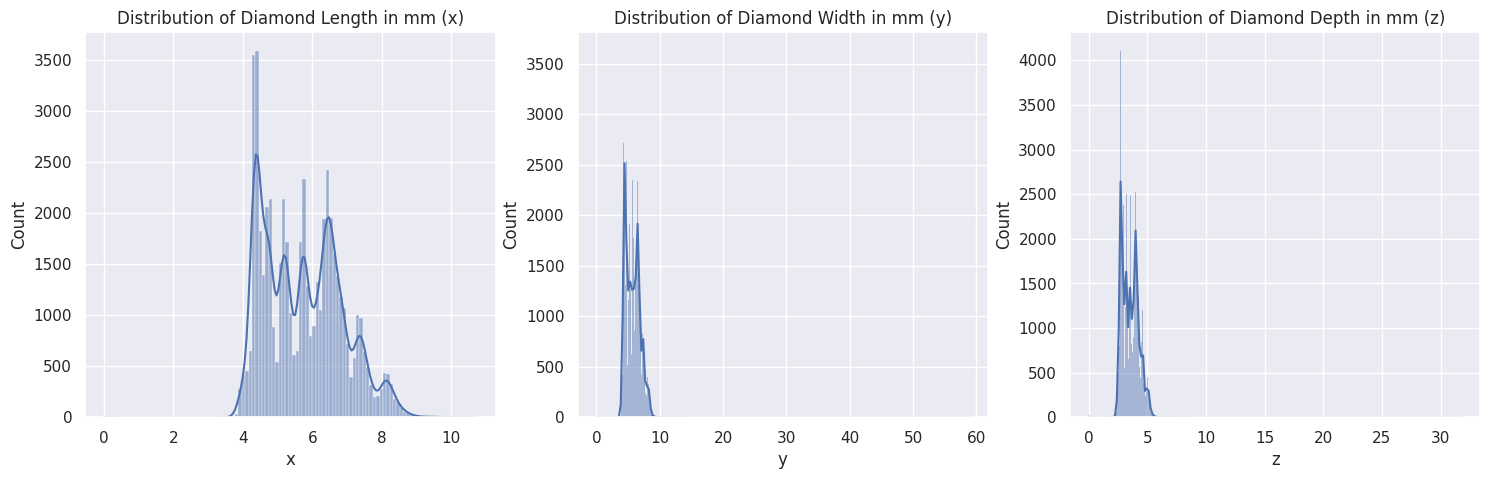

In [107]:
# Create a figure containing 3 subplots, using columns x,y, & z
columns = {
    'x': 'Length',
    'y': 'Width',
    'z': 'Depth'
}
fig, axes = plt.subplots(1, len(columns), figsize=(18, 5))
idx = 0

#Loop through the columns and generate plots
for col in columns:
  sns.histplot(diamond_df[col], kde=True, ax=axes[idx])
  axes[idx].set_title(f'Distribution of Diamond {columns[col]} in mm ({col})')
  idx += 1

plt.show()

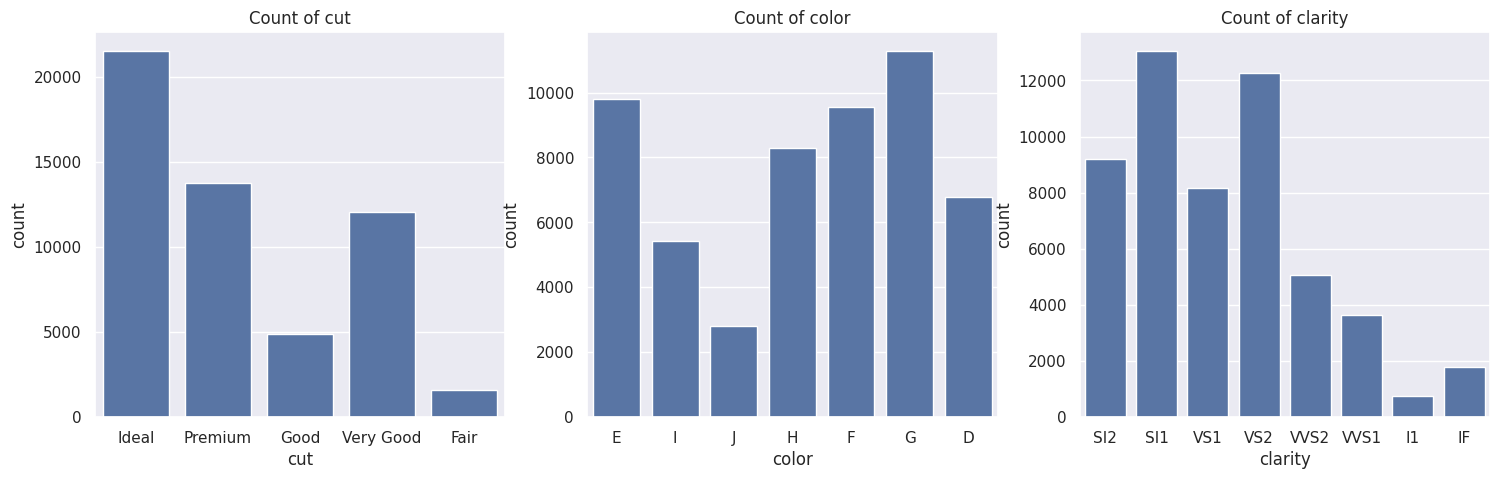

In [108]:
categorical_cols = diamond_df.dtypes[diamond_df.dtypes == object].index
fig, axes = plt.subplots(1, len(categorical_cols), figsize=(18, 5))
idx = 0

for col in categorical_cols:
    sns.countplot(x= diamond_df[col], ax=axes[idx])
    axes[idx].set_title(f'Count of {col}')
    idx += 1

plt.show()

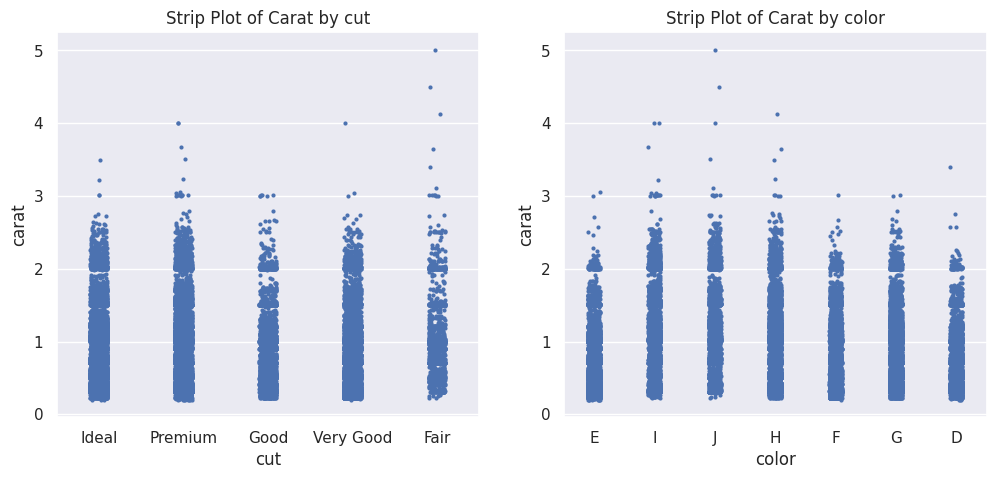

In [109]:
col_list = ['cut', 'color']
fig, axes = plt.subplots(1, len(col_list), figsize=(12, 5))
idx = 0

for col in col_list:
    sns.stripplot(x=col, y='carat', data=diamond_df, size=3, ax=axes[idx] )
    axes[idx].set_title(f'Strip Plot of Carat by {col}')
    idx += 1

plt.show()

[Text(0.5, 1.0, 'Diamond Depth by Table Scatterplot')]

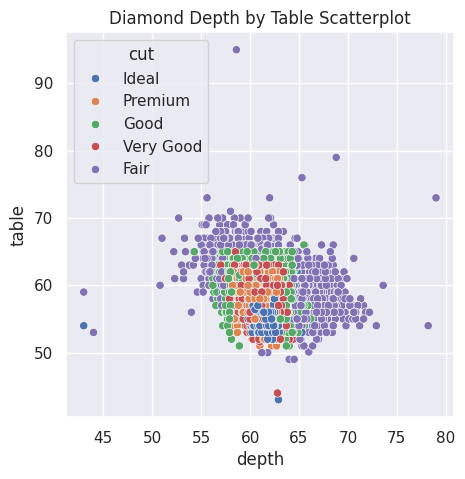

In [110]:
sns.scatterplot(data=diamond_df, x="depth", y="table", hue="cut").set(title="Diamond Depth by Table Scatterplot")

#Task 5: Perform Data Cleaning & Manipulation<br>
- There no missing values. However, a diamond with a length(x), width(y), or depth(z) of zero seems unrealistic, so such records will be removed.

In [111]:
diamond_df = diamond_df[(diamond_df['x'] != 0) & (diamond_df['y'] != 0) & (diamond_df['z'] != 0)]
print("Updated DataFrame dimensions:", diamond_df.shape)

Updated DataFrame dimensions: (53920, 10)


- Create necessary columns
  *   Diamond Approximate Volume in mm (length * width * depth)
  *   Length Width Ratio (length / width)



In [122]:
diamond_df['approx vol'] = diamond_df['x']*diamond_df['y']*diamond_df['z']
diamond_df['length width ratio'] = diamond_df['x']/diamond_df['y']
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,approx vol,length width ratio
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.992462
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.013021
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.995086
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.992908
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.997701


Convert the cut column into an ordered category

In [113]:
cut_categories = CategoricalDtype(categories=['Fair','Good', 'Very Good','Premium','Ideal' ], ordered=True)

diamond_df['cut']=diamond_df['cut'].astype(cut_categories)
#diamond_df.info()

#Task 6: Visualize Cleaned up Dataset

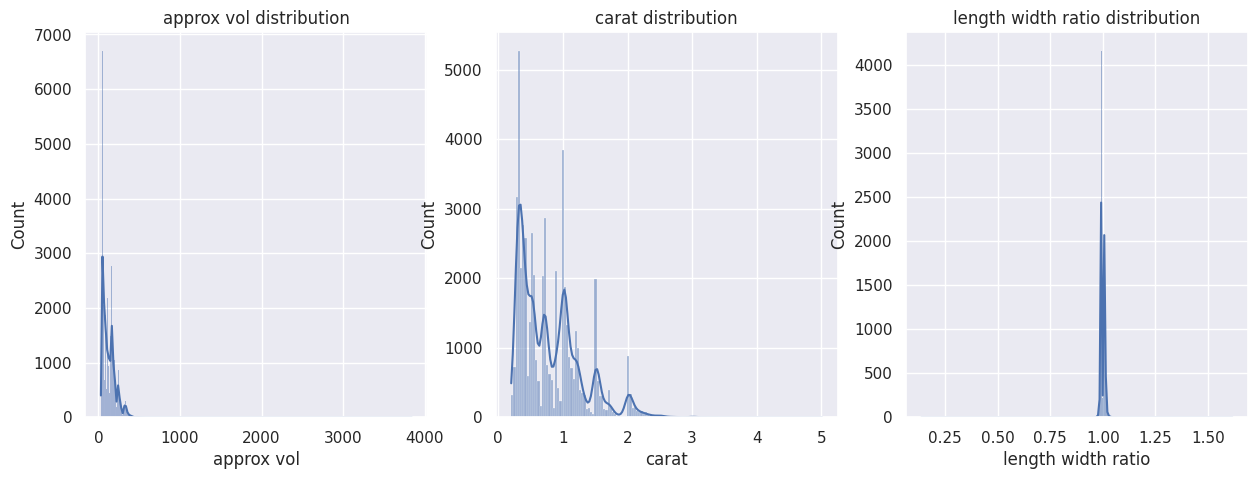

In [114]:
dist_columns = ['approx vol', 'carat', 'length width ratio']
fig, axes = plt.subplots(1, len(dist_columns), figsize=(15, 5))
idx = 0

#Loop through the columns and generate plots
for col in dist_columns:
  sns.histplot(diamond_df[col], kde=True, ax=axes[idx])
  axes[idx].set_title(f'{col} distribution')
  idx += 1

plt.show()

In [115]:
diamond_df[dist_columns].describe()

,approx vol,carat,length width ratio
count,53920.000000,53920.000000,53920.000000
mean,129.897567,0.797698,0.999425
std,78.219789,0.473795,0.011666
min,31.707984,0.200000,0.137351
25%,65.189759,0.400000,0.992625
50%,114.840180,0.700000,0.995745
75%,170.846415,1.040000,1.006944
max,3840.598060,5.010000,1.615572


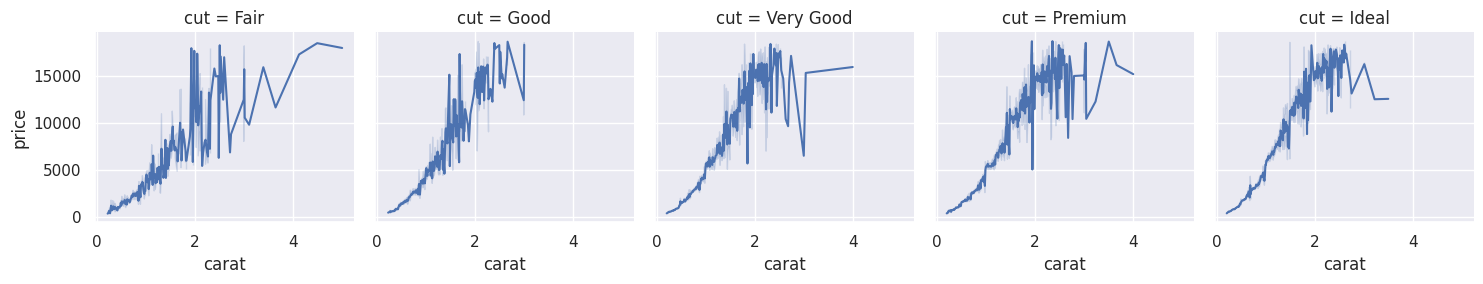

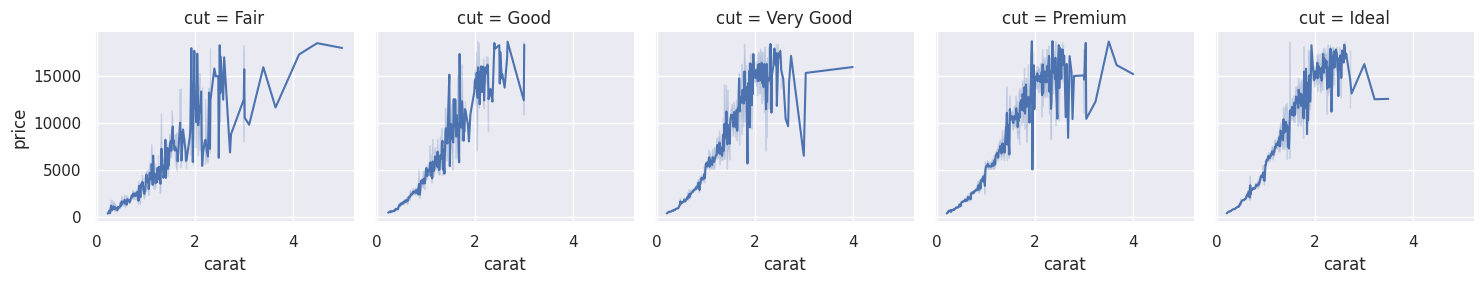

In [116]:
sns.FacetGrid(diamond_df, col="cut").map(sns.lineplot, "carat", "price");
sns.FacetGrid(diamond_df, col="cut").map(sns.lineplot, "carat", "price");

                       carat  approx vol     depth     table  \
carat               1.000000    0.978280  0.028259  0.181646   
approx vol          0.978280    1.000000  0.009039  0.167809   
depth               0.028259    0.009039  1.000000 -0.295733   
table               0.181646    0.167809 -0.295733  1.000000   
length width ratio  0.126739    0.041384  0.053081  0.128755   

                    length width ratio  
carat                         0.126739  
approx vol                    0.041384  
depth                         0.053081  
table                         0.128755  
length width ratio            1.000000  


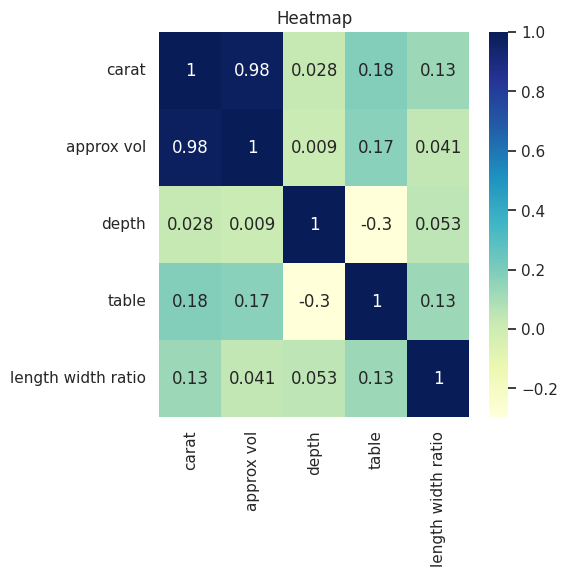

In [117]:
heat_cols=['carat', 'approx vol', 'depth', 'table','length width ratio']

print(diamond_df[heat_cols].corr())
sns.heatmap(diamond_df[heat_cols].corr(), cmap="YlGnBu", annot=True).set(title="Heatmap");

#Task 7: Conceptualize Question 1 & Train Models

Can a diamond's price be predicted by approximating its volume in milimeters?

For this analysis the approximate volume is calculated by multiplying the length, width, and depth. The precise calculation for volume varies based on the shape of the gem. This question will be answered using Linear Regression, because we're assuming a linear relationship between volume and price.

The volume linear regression model will be compared to a linear regression model for carat (weight).

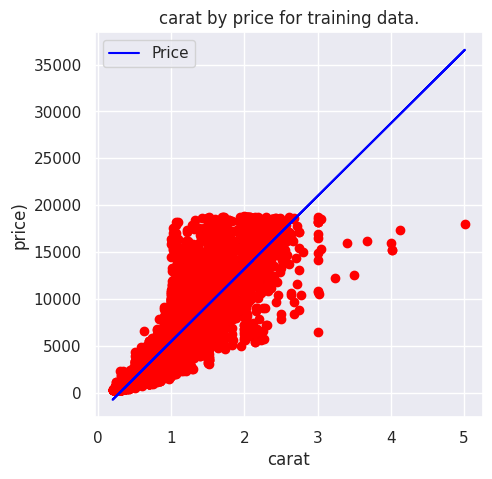

The Mean Squared Error for the carat feature is 2413751.06
The R squared score for the carat feature is 0.85.


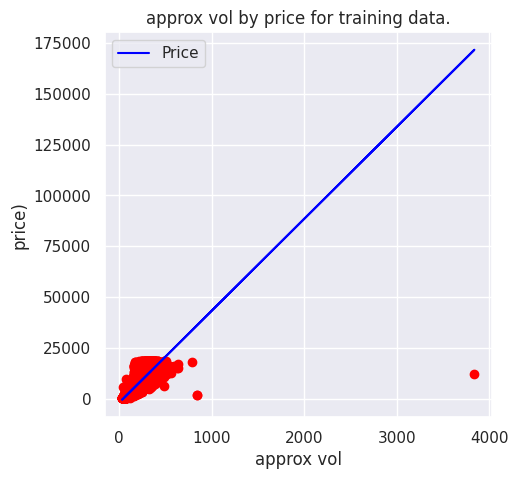

The Mean Squared Error for the approx vol feature is 2406789.96
The R squared score for the approx vol feature is 0.85.


In [118]:
#Run a linear regression model for each of the features
features = ['carat','approx vol']

for col in features:
  # Change X into 2D array
  X = np.array(diamond_df[col]).reshape(-1,1)
  y = diamond_df['price']

  #perform data split and train model
  x_train, x_test, y_train, y_test = train_test_split(X,y,  test_size = 0.3, random_state = 66)
  model = LinearRegression()
  model.fit(x_train, y_train)

  # Visualize training set with the prediction line
  plt.scatter(x_train, y_train, color = "red")
  plt.plot(x_train, model.predict(x_train), color = "blue", label="Price")
  plt.title(f"{col} by price for training data.")
  plt.xlabel(col)
  plt.ylabel("price)")
  plt.legend()
  plt.show()

  #Use Mean Squared Error and R-squared to compare the significance of each model (test)
  predictions = model.predict(x_test)
  mse = metrics.mean_squared_error(y_test, predictions)
  r2 = metrics.r2_score(y_test, predictions)
  print(f"The Mean Squared Error for the {col} feature is {round(mse, 2)}")
  print(f"The R squared score for the {col} feature is {round(r2,2) }.")

  #Save the model
  pickle.dump(model, open(f'/content/drive/MyDrive/Predictive Analytics/DiamondProject/{col}_model.pkl','wb'))

## Question 1 Findings<br>
Even though the model uses approximate volume, it performs as well as the carat model.

#Task 8: Conceptualize Question 2
Can the combination of depth, table, and length/width ratio be used to classify the diamand cut?<br>
According to the [International Gem Society](https://https://www.gemsociety.org/article/diamond-measurements/):
*   Depth percentage is the diamond's depth divided by its diameter.
*   A diamond's table is the flat facet on the top of the diamond; the ideal table percentage depends on the diamond's shape.
*   Length/Width Ratio -  is an approximator for the diamond's shape. For example, square and round diamonds have a length/width ratio thats close to 1, while rectangular and oval diamonds have a ratio that's closer to 2.<br>

Since the data is labeled, the following classification models will be trained and checked for accuracy:
*   Decision Tree Classifier
*   Random Forest Classifier
*   KNN Classifier

In [120]:
#select features & target
X = diamond_df[['depth', 'table', 'length width ratio']].values
y =  diamond_df['cut'].cat.codes.values #Convert cut into ordinal numeric categories

# perform data split and train models
x_train, x_test, y_train, y_test = train_test_split(X,y,  test_size = 0.2, random_state = 17)

dt_clf  = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)

dt_predictions = dt_clf.predict(x_test)
print("Decision Tree Classifier Accuracy Score:",metrics.accuracy_score(y_test, dt_predictions))
#pickle.dump(dt_clf, open(f'/content/drive/MyDrive/Predictive Analytics/DiamondProject/dt_clf_model.pkl','wb'))

rf_clf  = RandomForestClassifier()
rf_clf.fit(x_train, y_train)

rf_predictions = rf_clf.predict(x_test)
print("Random Forest Classifier Accuracy Score:",metrics.accuracy_score(y_test, rf_predictions))
#pickle.dump(rf_clf, open(f'/content/drive/MyDrive/Predictive Analytics/DiamondProject/rf_clf_model.pkl','wb'))

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)

knn_predictions = knn_clf.predict(x_test)
print("KNN Classifier Accuracy Score:",metrics.accuracy_score(y_test, knn_predictions))
pickle.dump(knn_clf, open(f'/content/drive/MyDrive/Predictive Analytics/DiamondProject/knn_clf_model.pkl','wb'))

Decision Tree Classifier Accuracy Score: 0.7216246290801187
Random Forest Classifier Accuracy Score: 0.7530600890207715
KNN Classifier Accuracy Score: 0.7718842729970327


K Value 1: Error Rate 0.27967359050445106
K Value 2: Error Rate 0.30415430267062316
K Value 3: Error Rate 0.23859421364985164
K Value 4: Error Rate 0.24452893175074183
K Value 5: Error Rate 0.22811572700296737
K Value 6: Error Rate 0.22626112759643918
K Value 7: Error Rate 0.2226446587537092
K Value 8: Error Rate 0.22301557863501484
K Value 9: Error Rate 0.22060459940652818
K Value 10: Error Rate 0.21865727002967358
K Value 11: Error Rate 0.2195845697329377
K Value 12: Error Rate 0.22004821958456974
K Value 13: Error Rate 0.22032640949554896
K Value 14: Error Rate 0.22190281899109793
K Value 15: Error Rate 0.22273738872403562
K Value 16: Error Rate 0.2235719584569733
K Value 17: Error Rate 0.22338649851632048
K Value 18: Error Rate 0.22431379821958458
K Value 19: Error Rate 0.22468471810089022


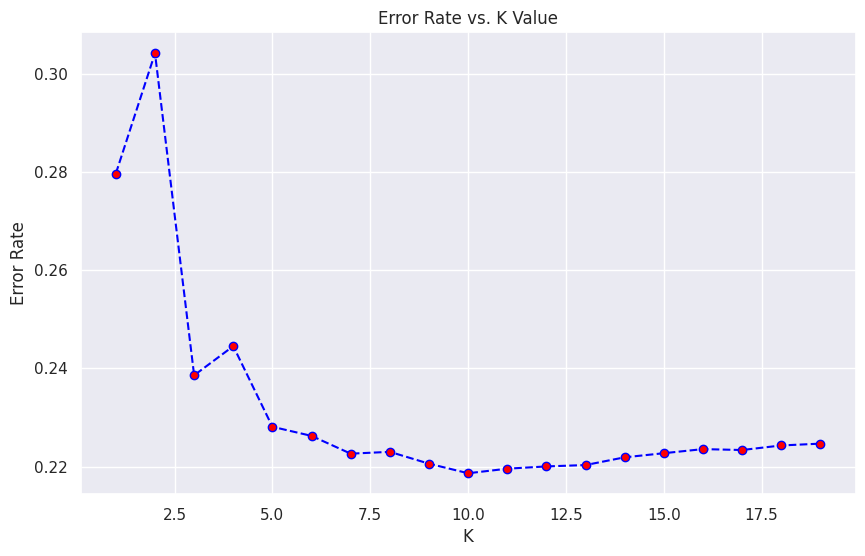

In [123]:
#Adjusting the KNN Classifier Model to improve performance
#The k value in the k-NN algorithm defines how many neighbors will be checked to determine the classification of a specific query point
error_rate = []
for i in range(1,20):

    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(x_train,y_train)
    pred_i = knn2.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))
    print(f"K Value {i}: Error Rate {error_rate[i-1]}")

plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=6)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');


## Question 2 Findings<br>
The KNN Classifier is consistently the most accurate model for identifying the diamond's cut. The error rate is lowest when k=10.

## Resources:
*   https://www.geeksforgeeks.org/seaborn-datasets-for-data-science#5-diamonds-dataset
*   https://www.gemsociety.org/article/diamond-measurements/